# Introduction to Neural Networks with Keras

### Layers

Simple vector data, stored in 2D tensors of shape `(samples, fearures)`, is often processed by _densely connected_ layers, also called _fully connected_ or _dense_ layers (the `Dense` class in Keras). 

Sequence data, stored in 3D tensors of shape `(samples, templates, features)`, is typically processed by recurrent layers such as `LSTM` layer. 

Image data, stored in 4D tensors, is usually processed by 2D convolution layers (`Conv2D`). 

Building deep-learnign models in Keras is done by clipping together compatible layers to form useful data-transformation pipelines. The notion of _layer compability_ here refers specifically to the fact that every layer will only accept input tensors of a certain shape and will return output tensors of a certain shape. 

In [1]:
from keras import layers

# A dense layer with 32 output units
layer = layers.Dense(32, input_shape=(784, ))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We're creating a layer that will only accept as input 2D tensors where the first dimension is 784 (axis 0, the batch dimension, is uncpecified, and thus any value would be accepted). This layer will return a tensor where the first dimension has been transformed to be 32. 

This this layer can only be connected to a downstream layer that expects 32-dimensional vectors as its input.

In [2]:
from keras import models

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))

The second layer didn't receive an input shape argument – instead, it automatically inferred its input shape as being the output shape of the layer that came before.

### Loss functions and optimizers

* Loss function (objective function) – The quantity that will be minimized during training. It represents a measure of success for the task at hand.

* Optimizer – Detemines how the network will be updated based on the loss function. It implements a specifc variant of stochastic gradient descent. 

__Binary crossentropy__ – for a two-class classification problem.
__Categorical crossentropy__ – for a many-class classification problem.
__Mean-squared error__ – for a regression problem. 
__Connectionist temporal classification__ - for a sequence-learning problems.

## Typical Keras Workflow

1. Define your training data: input tensors and target tensors.
2. Define a network of layers (or model) that maps your intputs to your targets.
3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor. 
4. Iterate on you training data by calling `fit()` method of your model.

There are two ways do define a model: using the `Sequential` class (only for linear stacks of layers) or the _functional API_ (for direct acyclic graphs of layers).

In [3]:
# Usign the Sequential class
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
# Using the functional API
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

The learning process is configured in the compilation step, where you specify the optimizer and loss function that the model should use, as well as the metrics you want to monitor during training.

In [5]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss='mse',
             metrics=['accuracy'])

Finally, the learning process consists of passing Numpy arrays of input data to the model via `fit()` method.

In [6]:
# model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)

## Classifying movie reviews: a binary classification example

In [7]:
# Load the dataset
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [8]:
# each review is a list of word indices
train_data[0][:5]

[1, 14, 22, 16, 43]

In [9]:
# each labes is 0 (negative) or 1 (positive)
train_labels[0]

1

### Preparing the data

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix
    results = np.zeros((len(sequences), dimension))
    # Set specific indices of results[i] to 1s
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [12]:
# Vectorize the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

### Building a network

Achitecture: 
* Two intermediate layers with 16 hidden units each
* A third layer that will output the scalar prediction regarding the sentiment of the current review

The intermediate layers will use `relu` as their activation function, and the final layer will user a sigmoid activation so as to output a probability.

In [13]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#### Why are activation functions necessary?

Without an activation function, the `Dense` layer would consist of two linear operations – a dot product and an addition. So the layer could only learn linear transformation of the input data: the hypothesis space of the layer would be the set of all possible linear trainsformations of the input data into a 16-dimensional space. In order to get access to a much richer hypothesis space that would benefit from deep representations, you need a non-linearity, or activation function. 

### Compiling the model

In [14]:
# model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

#### Configuring the optimizer, using custom losses and metrics

In [15]:
from keras import optimizers, losses, metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

### Validation the approach

In [16]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Training for 20 epochs, in mini-batches of 512 samples.

In [17]:
history = model.fit(partial_x_train,
                   partial_y_train, 
                   epochs=20,
                   batch_size=512, 
                   validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 245us/step - loss: 0.5084 - binary_accuracy: 0.7810 - val_loss: 0.3798 - val_binary_accuracy: 0.8682
Epoch 2/20
15000/15000 [==============================] - 2s 116us/step - loss: 0.3005 - binary_accuracy: 0.9043 - val_loss: 0.3002 - val_binary_accuracy: 0.8902
Epoch 3/20
15000/15000 [==============================] - 2s 111us/step - loss: 0.2179 - binary_accuracy: 0.9291 - val_loss: 0.3085 - val_binary_accuracy: 0.8711
Epoch 4/20
15000/15000 [==============================] - 2s 112us/step - loss: 0.1750 - binary_accuracy: 0.9437 - val_loss: 0.2843 - val_binary_accuracy: 0.8835
Epoch 5/20
15000/15000 [==============================] - 2s 111us/step - loss: 0.1426 - binary_accuracy: 0.9544 - val_loss: 0.2841 - val_binary_accuracy: 0.8870
Epoch 6/20
15000/15000 [==============================] - 2s 114us/step - loss: 0.1150 - binary_accuracy: 0.9652 - val_loss: 0.3155 - val_bi

The call to `model.fit()` returns a History object. This object has a member `history`, which is a dictionary containing data about everything that happened during training.

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

#### Plotting the training and validation loss

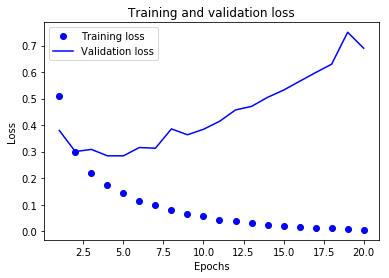

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['val_binary_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### Plotting the training and validation accuracy

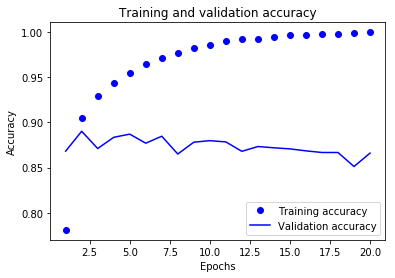

In [20]:
plt.clf() # Clear the figure

acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Retraining a model

In [21]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
25000/25000 [==============================] - 2s 89us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 2s 79us/step - loss: 0.2660 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 2s 76us/step - loss: 0.1983 - acc: 0.9296
Epoch 4/4
25000/25000 [==============================] - 2s 78us/step - loss: 0.1678 - acc: 0.9400: 1s - lo


In [24]:
results = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 4s 159us/step


In [25]:
results

[0.324519476852417, 0.87296]

### Using a trained network to generate predictoins on new data

In [26]:
model.predict(x_test)

array([[0.14040314],
       [0.99970406],
       [0.28377438],
       ...,
       [0.07108645],
       [0.04284972],
       [0.46800193]], dtype=float32)

### Testing a neural network with other hyperparameters

#### One more layer

In [27]:
model_3lay = models.Sequential()
model_3lay.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model_3lay.add(layers.Dense(16, activation='relu'))
model_3lay.add(layers.Dense(16, activation='relu'))
model_3lay.add(layers.Dense(1, activation='sigmoid'))

In [28]:
model_3lay.compile(optimizer=optimizers.RMSprop(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [29]:
model_3lay.fit(x_train, y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))

Train on 25000 samples, validate on 10000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 119us/step - loss: 0.4550 - acc: 0.8123 - val_loss: 0.3012 - val_acc: 0.8975
Epoch 2/4
25000/25000 [==============================] - 3s 105us/step - loss: 0.2540 - acc: 0.9100 - val_loss: 0.1839 - val_acc: 0.9431
Epoch 3/4
25000/25000 [==============================] - 3s 107us/step - loss: 0.1947 - acc: 0.9306 - val_loss: 0.1819 - val_acc: 0.9323
Epoch 4/4
25000/25000 [==============================] - 3s 134us/step - loss: 0.1644 - acc: 0.9406 - val_loss: 0.1212 - val_acc: 0.9639


In [30]:
results = model_3lay.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 83us/step


In [31]:
results

[0.30067968824863434, 0.88292]

Model with 3 layers, the `rmsprop` optimizer and the `binary_crossentropy` loss function the result accuracy increased to 0.88 while the loss is 0.299

#### Model with 2 layers of 32 units 

In [32]:
model_32units = models.Sequential()
model_32units.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model_32units.add(layers.Dense(32, activation='relu'))
model_32units.add(layers.Dense(1, activation='sigmoid'))

In [33]:
model_32units.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [34]:
history = model_32units.fit(x_test, 
                  y_test, 
                  epochs=4, 
                  batch_size=512,
                  validation_data=(x_val, y_val))

Train on 25000 samples, validate on 10000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 120us/step - loss: 0.4394 - acc: 0.8203 - val_loss: 0.3381 - val_acc: 0.8652
Epoch 2/4
25000/25000 [==============================] - 3s 103us/step - loss: 0.2395 - acc: 0.9120 - val_loss: 0.2792 - val_acc: 0.8892
Epoch 3/4
25000/25000 [==============================] - 3s 111us/step - loss: 0.1811 - acc: 0.9333 - val_loss: 0.2909 - val_acc: 0.8878
Epoch 4/4
25000/25000 [==============================] - 3s 127us/step - loss: 0.1543 - acc: 0.9424 - val_loss: 0.3156 - val_acc: 0.8828


In [35]:
model_32units.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 104us/step


[0.11154035776376724, 0.9632]

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

<Figure size 432x288 with 0 Axes>

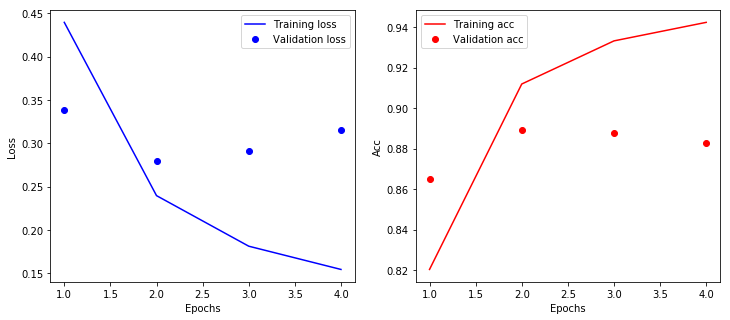

In [37]:
plt.clf()
plt.figure(figsize=(12, 5))
training_loss = history_dict['loss']
training_acc = history_dict['acc']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_acc']

epochs = range(1, len(val_acc) + 1)


plt.subplot(121)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, training_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

## Classifying newswires: a multiclass classification example

In [38]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [39]:
len(train_data)

8982

In [40]:
len(test_data)

2246

In [41]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [42]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [43]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### Preparing the data

In [44]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [45]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [46]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [47]:
# There is a built-in way to do this in Keras:

# from keras.utils.np_utils import to_categorical
# one_hot_train_labels = to_categorical(train_labels)
# one_hot_test_labels = to_categorical(test_labels)

In [48]:
one_hot_test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [50]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [51]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [52]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20, 
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 182us/step - loss: 2.5241 - acc: 0.4977 - val_loss: 1.7183 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 117us/step - loss: 1.4443 - acc: 0.6888 - val_loss: 1.3498 - val_acc: 0.7090
Epoch 3/20
7982/7982 [==============================] - 1s 120us/step - loss: 1.0994 - acc: 0.7642 - val_loss: 1.1748 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 120us/step - loss: 0.8730 - acc: 0.8153 - val_loss: 1.0836 - val_acc: 0.7580
Epoch 5/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.7063 - acc: 0.8492 - val_loss: 0.9870 - val_acc: 0.7850
Epoch 6/20
7982/7982 [==============================] - 1s 114us/step - loss: 0.5699 - acc: 0.8794 - val_loss: 0.9414 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.4627 - acc: 0.9037 - val_loss: 0.9089 - val_acc: 0.8030


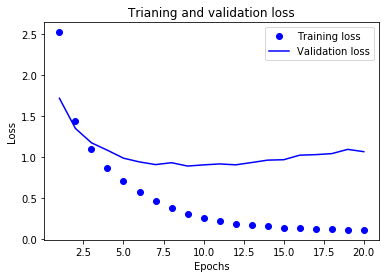

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trianing and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

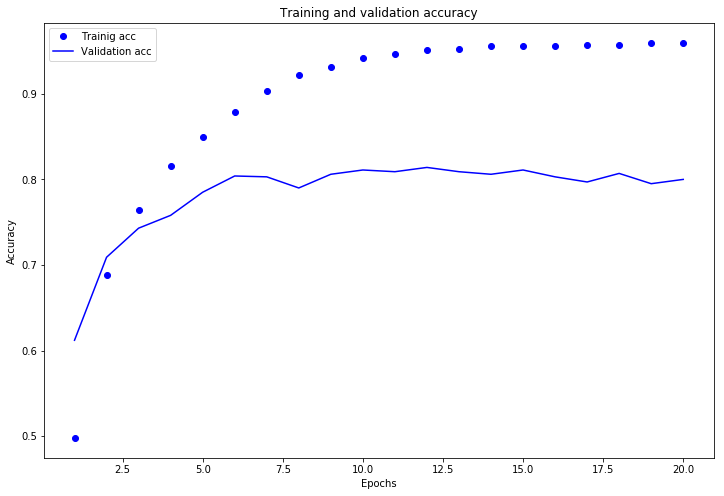

In [54]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(12, 8))

plt.plot(epochs, acc, 'bo', label='Trainig acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The network begins to overfit after nine epochs. 

In [55]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, 
         partial_y_train, 
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 145us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 111us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 110us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 109us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 109us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 109us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 109us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [56]:
results = model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 145us/step


In [57]:
results

[1.022498250538392, 0.7756010686194165]

### Wrapping up

* If you're trying to classify data points among N classes, your network should end with a Dense layer of size N.
* In a single-labeled, multiclass classification problem, your network should end with a softmax activation funciton so that it will output a probability distribution over the N output classes.
* Categorical crossentropy is almost always the loss function you should use for such problems. 
* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.

##  Prediction house prices: a regressing example

In [58]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 4us/step


In [60]:
train_data.shape

(404, 13)

In [61]:
test_data.shape

(102, 13)

The targets are the median values of owner-ocupied homes, in thousands of dollars:

In [66]:
train_targets[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

#### Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. A widespread best practice to deal with such data is to do featire-wise normalization: for each feature in the input data, you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [67]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### Building the network

Because so few samples are available, we will use a very small network with two hidden layers. In general, the less training data we have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.

In [71]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # no activation because this is the linear layer
    # using the mean squared error loss function 
    # and the mean absolute error metric:
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### K-fold validation

It consists of splitting the available data into K partions, instantiating K identical models, and trainng each one on K - 1 partions while evaluating on the remaining partion. The validation score for the model used is then the average of the K validation scores obrained.

In [88]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # Prepare the validation data from partion #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepare the training data from all other partions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Build the Keras model
    model = build_model()

    # Train the model in silent mode (verbose = 0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [89]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

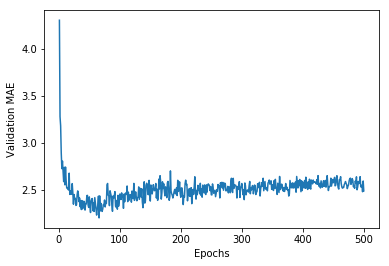

In [90]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plotting validation scores, excluding the first 10 data points 

In [91]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

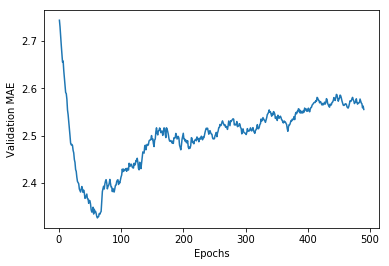

In [92]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [93]:
num_epochs = 80
batch_size = 16

model = build_model()
model.fit(train_data, train_targets,
         epochs=num_epochs, batch_size=batch_size, verbose=0)

In [94]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [95]:
test_mae_score

2.823090721579159

### Wrapping up 

* Regression is done using different loss functions than what we used for classification. Mean squared error is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification.
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it's preferable to use a small network with few hidden layers, in order to avoid severe overfitting. 